<a href="https://colab.research.google.com/github/hero-hub/cnn_psf/blob/main/cnn_resnet_2layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
import sys

2025-06-18 14:28:50.525359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750256930.980594      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750256931.091399      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Загрузка и подготовка данных


In [2]:
# Путь к папке, где находится library_help_tools.py
sys.path.insert(0, '/kaggle/input/toolss')

print(sys.path)

try:
    import library_help_tools as lht
    print("Модуль успешно импортирован!")
except ModuleNotFoundError as e:
    print(f"Ошибка импорта: {e}")

# Максимальная абсолютная ошибка
def max_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Приводим y_true к float32
    y_pred = tf.cast(y_pred, tf.float32)  # Приводим y_pred к float32
    return tf.reduce_max(tf.abs(y_true - y_pred))

['/kaggle/input/toolss', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython']
Модуль успешно импортирован!


In [3]:
zip_directory = '/kaggle/input/128-16090-20x/128_16090_20x/'
print(os.listdir())

def load_images_from_directory(dir_read):
    images = []  # Список для хранения изображений
    list_file = os.listdir(dir_read)  # Получаем список файлов в директории

    for cur_file in list_file:
        cur_file_path = os.path.join(dir_read, cur_file)
        try:
            img = Image.open(cur_file_path)
            images.append(img)
        except Exception as e:
            print(f"Ошибка при чтении файла {cur_file_path}: {e}")

    print(f'Количество загруженных изображений - {len(images)}')
    return images

images = load_images_from_directory(zip_directory)

['__notebook__.ipynb']
Количество загруженных изображений - 16090


In [4]:
# Создаем словарь с параметрами
GVD = dict(
    DATA_DIR = zip_directory,
    FILE_FORMAT = ".png",
    IMG_SIZE = 128,
    TEST_SPLIT = 0.2,
    VALIDATION_SPLIT = 0.2,
    SEED = 123
)

In [5]:
# Загрузка данных
ts_images, ts_labels = lht.load_data(lht.list_files(GVD['DATA_DIR'], GVD['FILE_FORMAT']))

# Преобразование в numpy массивы
ts_images = np.array(ts_images)
ts_labels = np.array(ts_labels)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    ts_images, ts_labels, test_size=0.2, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Преобразование в tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

I0000 00:00:1750257102.284232      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750257102.285012      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Создание модели

In [6]:
# Входной слой
inputs = layers.Input(shape=(128, 128, 1))  #128x128 и ЧБ (1 канал)

# Предварительные сверточные слои
x = layers.Conv2D(64, 3, activation='gelu', padding='same')(inputs)
x = layers.Conv2D(128, 5, activation='gelu', padding='same')(x)

# ResNet50
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=x,  # Передаем выход предыдущего слоя
    pooling='avg'  # Глобальное усреднение
)

# Выходной слой
outputs = layers.Dense(2, activation='linear')(resnet.output)

# Создание модели
model = models.Model(inputs=inputs, outputs=outputs)

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        max_error
    ]
)

# Обучение модели

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_rmse')
    ]
)

Epoch 1/8


I0000 00:00:1750257194.527438      62 service.cc:148] XLA service 0x7b9bd0027e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750257194.529215      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750257194.529236      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750257199.224211      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750257229.031940      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 326.4847 - max_error: 14.7381 - rmse: 15.2553

E0000 00:00:1750257327.450639      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750257327.716481      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


322/322 ━━━━━━━━━━━━━━━━━━━━ 217s 412ms/step - loss: 324.9053 - max_error: 14.6869 - rmse: 15.2132 - val_loss: 86.1142 - val_max_error: 27.3370 - val_rmse: 9.2798
Epoch 2/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 96s 298ms/step - loss: 2.6194 - max_error: 2.5814 - rmse: 1.6152 - val_loss: 4.0970 - val_max_error: 3.3907 - val_rmse: 2.0241
Epoch 3/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - loss: 1.2629 - max_error: 1.8806 - rmse: 1.1187 - val_loss: 4.4445 - val_max_error: 3.9464 - val_rmse: 2.1082
Epoch 4/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - loss: 1.0313 - max_error: 1.7524 - rmse: 1.0105 - val_loss: 1.4316 - val_max_error: 2.1431 - val_rmse: 1.1965
Epoch 5/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 95s 296ms/step - loss: 0.3688 - max_error: 1.1847 - rmse: 0.6064 - val_loss: 0.1864 - val_max_error: 0.9362 - val_rmse: 0.4318
Epoch 6/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 95s 294ms/step - loss: 0.2695 - max_error: 1.0573 - rmse: 0.5179 - val_loss: 0.0893 - val_max_error: 0.9080 - val_rmse: 0.2988
Epoch 7

# Оценка и визуализация


Ошибки на тестовом наборе:
RMSE: 2.11 пикселей
Максимальная ошибка: 2.97 пикселей


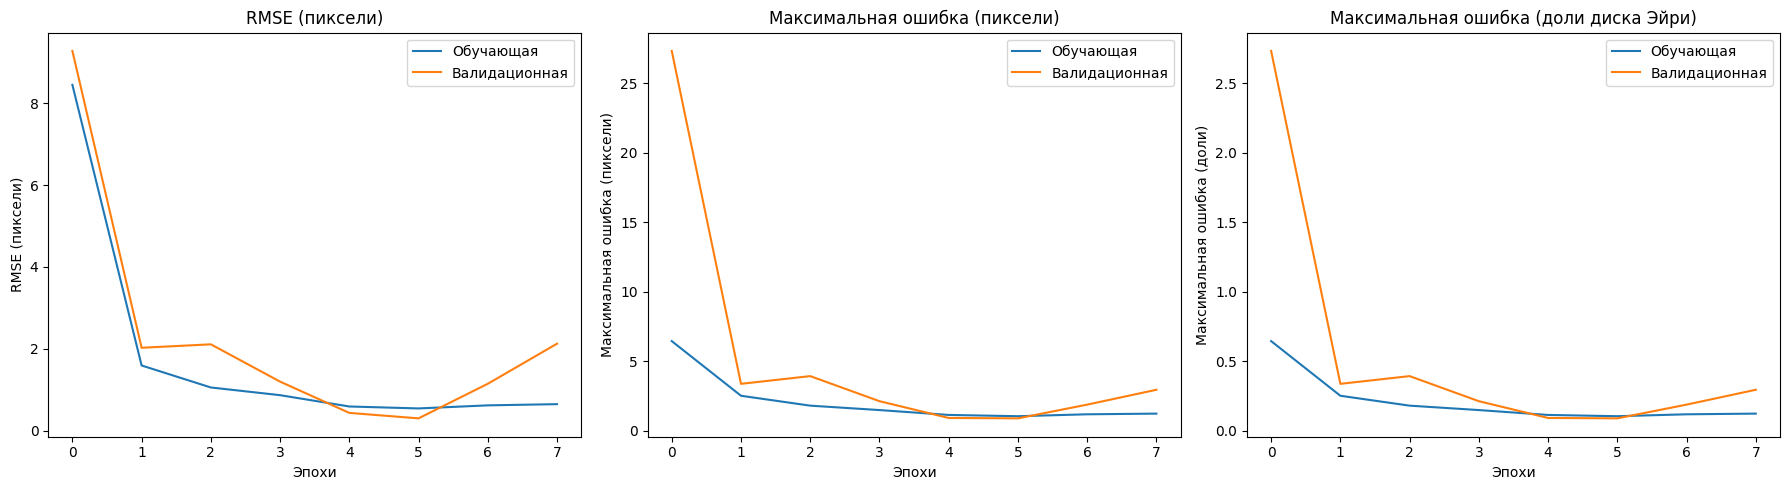

In [8]:
# Оценка на тестовом наборе
test_loss, test_rmse, test_max_error = model.evaluate(test_ds, verbose=0)
print(f"\nОшибки на тестовом наборе:")
print(f"RMSE: {test_rmse:.2f} пикселей")
print(f"Максимальная ошибка: {test_max_error:.2f} пикселей")

# Предполагаем, что диаметр диска Эйри = 10 пикселей
airy_diameter = 10.0

# Визуализация обучения
plt.figure(figsize=(18, 5))

# График RMSE
plt.subplot(1, 3, 1)
plt.plot(history.history['rmse'], label='Обучающая')
plt.plot(history.history['val_rmse'], label='Валидационная')
plt.title('RMSE (пиксели)')
plt.xlabel('Эпохи')
plt.ylabel('RMSE (пиксели)')
plt.legend()

# График максимальной ошибки в пикселях
plt.subplot(1, 3, 2)
plt.plot(history.history['max_error'], label='Обучающая')
plt.plot(history.history['val_max_error'], label='Валидационная')
plt.title('Максимальная ошибка (пиксели)')
plt.xlabel('Эпохи')
plt.ylabel('Максимальная ошибка (пиксели)')
plt.legend()

# График максимальной ошибки в долях диаметра диска Эйри
plt.subplot(1, 3, 3)
plt.plot(np.array(history.history['max_error']) / airy_diameter, label='Обучающая')
plt.plot(np.array(history.history['val_max_error']) / airy_diameter, label='Валидационная')
plt.title('Максимальная ошибка (доли диска Эйри)')
plt.xlabel('Эпохи')
plt.ylabel('Максимальная ошибка (доли)')
plt.legend()

plt.tight_layout()
plt.show()

Влияния смещения на ФПМ

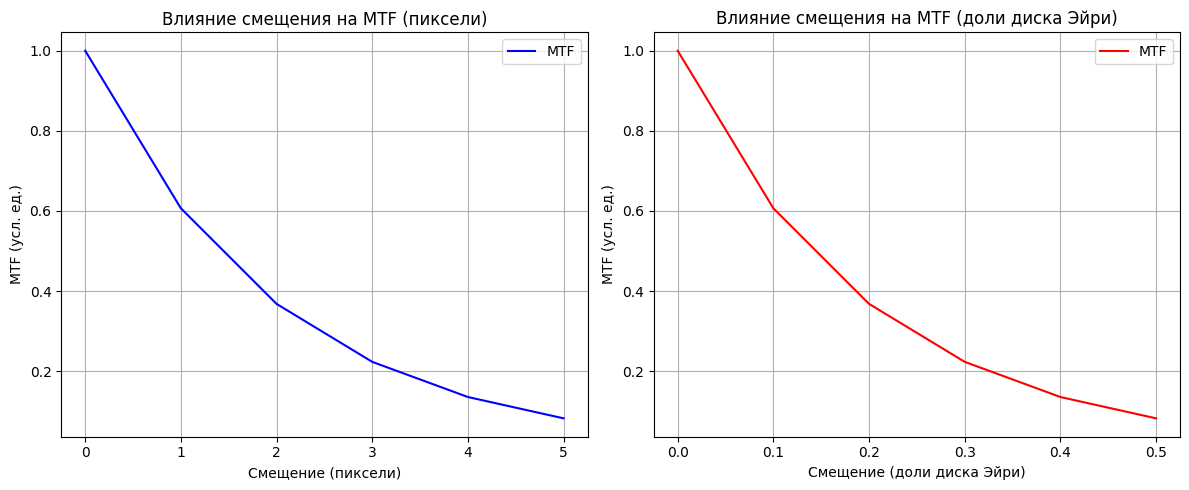

In [9]:
# Смещение в пикселях и долях диска Эйри
airy_diameter = 10.0
offsets_pixels = np.linspace(0, 5, 6)  # Смещение от 0 до 5 пикселей
offsets_airy = offsets_pixels / airy_diameter  # Смещение в долях диска Эйри

# Синтетические данные MTF (экспоненциальное уменьшение)
mtf_values = np.exp(-offsets_pixels / 2)  # Пример: MTF уменьшается с ростом смещения

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(offsets_pixels, mtf_values, label='MTF', color='blue')
plt.title('Влияние смещения на MTF (пиксели)')
plt.xlabel('Смещение (пиксели)')
plt.ylabel('MTF (усл. ед.)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(offsets_airy, mtf_values, label='MTF', color='red')
plt.title('Влияние смещения на MTF (доли диска Эйри)')
plt.xlabel('Смещение (доли диска Эйри)')
plt.ylabel('MTF (усл. ед.)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Предсказание на случайном изображении из датасета

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


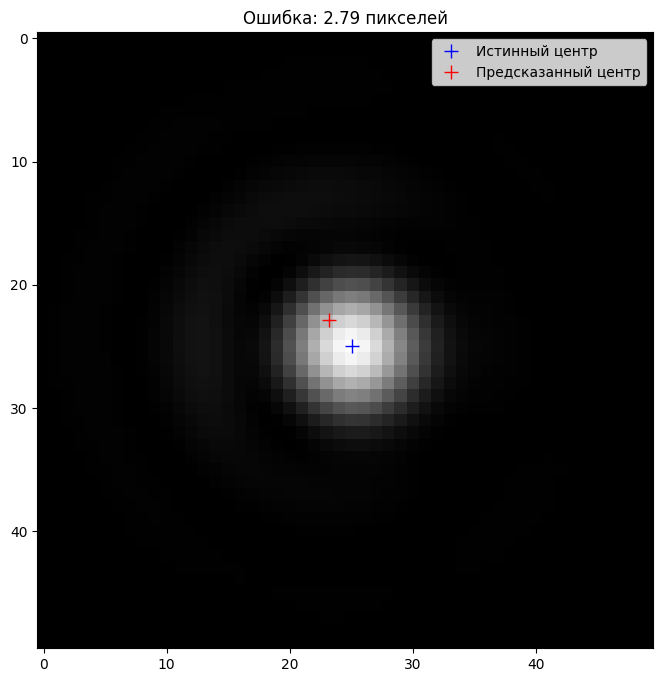

In [10]:
import random

# Тестовый датасет в виде списка
test_images = list(test_ds.unbatch().as_numpy_iterator())

# Выбираем случайное изображение
random_sample = random.choice(test_images)
sample_image = random_sample[0]
true_center = random_sample[1]

# Обрезаем изображение вокруг центра, чтобы пятно было крупнее
crop_size = 50  # Новый размер изображения 50x50
center_x, center_y = int(true_center[1]), int(true_center[0])
start_x = max(0, center_x - crop_size // 2)
start_y = max(0, center_y - crop_size // 2)
end_x = min(sample_image.shape[1], start_x + crop_size)
end_y = min(sample_image.shape[0], start_y + crop_size)
cropped_image = sample_image[start_y:end_y, start_x:end_x]

# Корректируем координаты центра для обрезанного изображения
adjusted_true_center = [true_center[0] - start_y, true_center[1] - start_x]

# Предсказание
sample_image_pred = sample_image[np.newaxis, ...]  # Добавляем batch-размерность
predicted_center = model.predict(sample_image_pred)[0]

# Корректируем предсказанные координаты для обрезанного изображения
adjusted_pred_center = [predicted_center[0] - start_y, predicted_center[1] - start_x]

# Отображение результата
plt.figure(figsize=(8, 8))
plt.imshow(cropped_image.squeeze(), cmap='gray')
plt.plot(adjusted_true_center[1], adjusted_true_center[0], 'b+', markersize=10, markeredgewidth=1, label='Истинный центр')
plt.plot(adjusted_pred_center[1], adjusted_pred_center[0], 'r+', markersize=10, markeredgewidth=1, label='Предсказанный центр')
plt.title(f"Ошибка: {np.linalg.norm(np.array(adjusted_true_center) - np.array(adjusted_pred_center)):.2f} пикселей")
plt.legend()
plt.show()

# Сохранение модели

In [11]:
#model_path = '/content/drive/My Drive/Colab_Notebooks/psf_center_model.h5'
#model.save(model_path)

# Сохранение истории обучения
#import pickle
#history_path = '/content/drive/My Drive/Colab_Notebooks/history.pkl'
#with open(history_path, 'wb') as f:
#    pickle.dump(history.history, f)